In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [20]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import timedelta

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import inspect

In [4]:
# create engine to hawaii.sqlite
database_path = "Resources/hawaii.sqlite"
# print(database_path)
engine = create_engine(f"sqlite:///{database_path}")
# conn = engine.connect()

In [5]:
# reflect an existing database into a new model
Base = automap_base()

In [6]:
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [12]:
# Create our session (link) from Python to the DB
session=Session(engine)

In [82]:
# Get the name of the columns for all the tables in the schema
inspector = inspect(engine)
schemas = inspector.get_schema_names()

print(schemas)
print("------------")
for schema in schemas:
    print("schema: %s" % schema)
    print("------------")
    for table_name in inspector.get_table_names(schema=schema):
        print(table_name)
        print("------------")
        for column in inspector.get_columns(table_name, schema=schema):
            print(column["name"],column["type"])

['main']
------------
schema: main
------------
measurement
------------
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
station
------------
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Precipitation Analysis

In [19]:
# Find the most recent date in the data set.
most_recent_dt=session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(f"The most recent date is {most_recent_dt}")

The most recent date is ('2017-08-23',)


In [49]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
last_year_dt = dt.date(2017,8,23)-dt.timedelta(days=365)


# Perform a query to retrieve the data and precipitation scores
max_prcp =session.query(Measurement.date,func.max(Measurement.prcp)).filter(Measurement.date>=last_year_dt).\
 group_by(Measurement.date).all()
                                                                            
# Save the query results as a Pandas DataFrame and set the index to the date column
max_prcpdf = pd.DataFrame(max_prcp,columns=["Precip_Date","Precip_Value"]).set_index("Precip_Date")

# Sort the dataframe by date
max_prcpdf.sort_values(by="Precip_Date",ascending=True)

max_prcpdf     

,Precip_Value
Precip_Date,
2016-08-23,1.79
2016-08-24,2.28
2016-08-25,0.21
2016-08-26,0.04
2016-08-27,0.18
...,...
2017-08-19,0.09
2017-08-20,0.01
2017-08-21,0.56


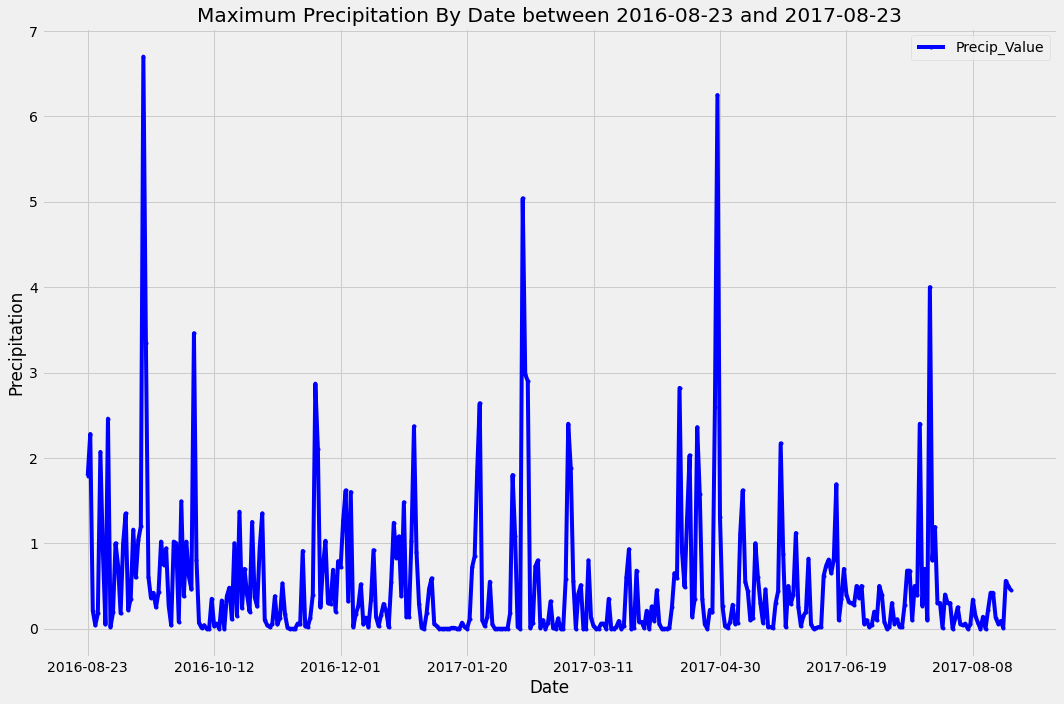

In [84]:
# Use Pandas Plotting with Matplotlib to plot the data            
max_prcpdf.plot.line(title=f"Maximum Precipitation By Date between {last_year_dt} and {dt.date(2017,8,23)}", \
                     color = 'b', figsize=(15, 10), style='.-')
plt.xlabel("Date")
plt.ylabel("Precipitation")
plt.tight_layout()
plt.savefig("Images/Precip.png")
plt.show()                

In [61]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip =session.query(Measurement.date,Measurement.prcp).filter(Measurement.date>=last_year_dt).all()
precip_pd = pd.DataFrame(precip,columns=["Precip_Date","Precip_Value"]).set_index("Precip_Date")

# Display the statistics
precip_pd.describe()

,Precip_Value
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [63]:
# Design a query to calculate the total number stations in the dataset
total_station = session.query(Station.name).count()
print(f"The total number of stations are {total_station}")

The total number of stations are 9


In [70]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_station = session.query(Measurement.station, Station.name, func.count(Measurement.station)).\
    group_by(Measurement.station).join(Station, Measurement.station == Station.station, isouter=True).\
    order_by(func.count(Measurement.station).desc()).all()

for station in active_station:
    print(station)
    
print("---------------------------------------------------------------------")
print(f"The most active station is: {active_station[0][1]} , Station ID ({active_station[0][0]}).")

('USC00519281', 'WAIHEE 837.5, HI US', 2772)
('USC00519397', 'WAIKIKI 717.2, HI US', 2724)
('USC00513117', 'KANEOHE 838.1, HI US', 2709)
('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 2669)
('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 2612)
('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 2202)
('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 1979)
('USC00517948', 'PEARL CITY, HI US', 1372)
('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 511)
---------------------------------------------------------------------
The most active station is: WAIHEE 837.5, HI US , Station ID (USC00519281).


In [74]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
temp_stats = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
filter(Measurement.station=='USC00519281').all()

print(f"Minimum Temp for Station - USC00519281 is {temp_stats[0][0]}")
print(f"Maximum Temp for Station - USC00519281 is {temp_stats[0][1]}")
print(f"Average Temp for Station - USC00519281 is {temp_stats[0][2]}")

Minimum Temp for Station - USC00519281 is 54.0
Maximum Temp for Station - USC00519281 is 85.0
Average Temp for Station - USC00519281 is 71.66378066378067


In [75]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and store into a Panda

temps =session.query(Measurement.date,Measurement.tobs).filter(Measurement.date>=last_year_dt).\
filter(Measurement.station == 'USC00519281').all()
temps_pd = pd.DataFrame(temps,columns=["Temp_Date","Temp_Value"]).set_index("Temp_Date")

# Display the Panda
temps_pd

,Temp_Value
Temp_Date,
2016-08-23,77.0
2016-08-24,77.0
2016-08-25,80.0
2016-08-26,80.0
2016-08-27,75.0
...,...
2017-08-14,77.0
2017-08-15,77.0
2017-08-16,76.0


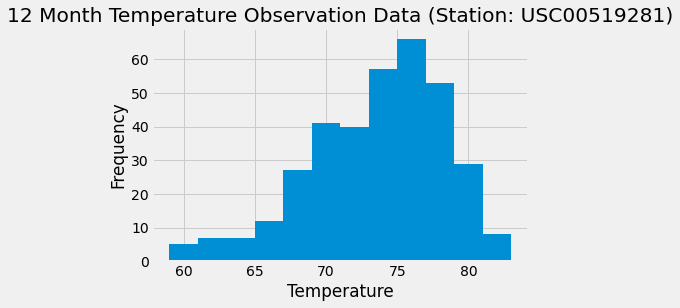

In [83]:
# Plot the data into a histogram
plt.hist(temps_pd,bins=12) 

# Format the plot
plt.title(f"12 Month Temperature Observation Data (Station: {active_station[0][0]})")
plt.xlabel("Temperature")
plt.ylabel("Frequency")

# Save the plot as a .png file
plt.savefig("Images/Temp_Analysis.png")

# Display the plot
plt.show()


# Close session

In [ ]:
# Close Session
session.close()